In [1]:
# evaluation of models on the test set using inputs from the ProtoASNet model in particular
# (which already has 3-way classification)

import os
import numpy as np
import pandas as pd
import glob
import re
from scipy.special import softmax

from scipy.io import loadmat
from skimage.transform import resize
from sklearn.metrics import f1_score, confusion_matrix, balanced_accuracy_score, accuracy_score
import matplotlib.pyplot as plt

from platt_scaling import platt_scaling_fit
from conformal_pred_algos import *
from conformal_pred_metrics import *

In [2]:
# experimental settings
dataset = 'AS'
mode = 'ProtoASNet' # required for AS dataset
MAP_TO_STUDY_LEVEL = True

In [3]:
# start by obtaining, for each method, the validation and test prediction logits
methods = ['v0', 'v0+', 'v1', 'v1+', 'v1++']
log_root = '../logs/protoasnet/'
val_csvs = ['v0/round0/val.csv', 'v0/round1/val.csv', 'v1/round0/val.csv', 'v1/round1/val.csv', 'v1/round2/val.csv']
test_csvs = ['v0/round0/test.csv', 'v0/round1/test.csv', 'v1/round0/test.csv', 'v1/round1/test.csv', 'v1/round2/test.csv']
data_info_df = pd.read_csv("../logs/AS_Prev/annotations-all.csv")
data_info_df['base_id'] = data_info_df['path'].apply(os.path.basename)

val_csvs = [log_root + m for m in val_csvs]
test_csvs = [log_root + m for m in test_csvs]

In [4]:
# collect the dataframes
df_val = [pd.read_csv(x).sort_values(by=['filename']).reset_index() for x in val_csvs]
df_test = [pd.read_csv(x).sort_values(by=['filename']).reset_index() for x in test_csvs]

In [5]:
# put the preds back into the val/test dataframes
def add_pred_columns_to_df(df):
    cols = [x for x in df.columns if 'logit' in x]
    logits = df[cols].to_numpy()
    preds = softmax(logits, axis=1)
    for j in range(preds.shape[1]):
        df[f'preds_{j}'] = preds[:, j]

for i in range(len(methods)):
    add_pred_columns_to_df(df_test[i])
    add_pred_columns_to_df(df_val[i])

In [6]:
df_val[0]

,index,Unnamed: 0,filename,target_AS,interval_idx,window_start,window_end,original_length,logit_No AS,logit_Early AS,logit_Significant AS,logit_abstain,preds_0,preds_1,preds_2,preds_3
0,335,335,001_1.2.840.113619.2.239.7558.1422601452.0.163...,2,0,0,64,67,2.728096,3.633309,7.203196,6.959469,0.006247,0.015444,0.548471,0.429838
1,0,0,001_1.2.840.113619.2.239.7558.1424675902.0.8.5...,1,0,0,40,45,2.969994,7.529570,4.441368,6.874915,0.006643,0.634650,0.028930,0.329778
2,481,481,001_1.2.840.113619.2.239.7558.1429688380.0.132...,0,0,0,42,46,8.599772,2.680257,1.289705,6.739426,0.862832,0.002318,0.000577,0.134273
3,482,482,001_1.2.840.113619.2.239.7558.1435223245.0.550...,0,0,0,34,37,8.175800,2.718631,1.293249,6.786229,0.797147,0.003400,0.000817,0.198635
4,483,483,001_1.2.840.113619.2.239.7558.1441355109.0.109...,0,0,0,29,35,8.389790,2.690062,1.303227,6.770885,0.831740,0.002784,0.000696,0.164781
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1275,943,943,237_1.2.840.113663.1500.1.346625331.3.24.20140...,2,0,0,66,119,2.756157,6.004035,5.503255,6.826364,0.009911,0.255056,0.154579,0.580455
1276,944,944,241_1.2.840.113663.1500.1.346625331.3.28.20140...,2,0,0,36,73,2.818296,6.019743,4.188177,6.775659,0.012222,0.300262,0.048091,0.639426
1277,945,945,241_1.2.840.113663.1500.1.346625331.3.28.20140...,2,1,36,72,73,2.811073,4.919791,6.336881,6.876797,0.009850,0.081139,0.334705,0.574307
1278,946,946,246_1.2.840.113663.1500.1.346625331.3.33.20140...,2,0,0,50,102,3.241830,6.883306,3.929804,6.830102,0.012935,0.493448,0.025737,0.467881


In [7]:
def studyinfo_from_query_key(s):
    # Define the regular expression pattern
    pattern = r'(\d+)s(\d+)_(\d+)\.png'
    
    # Use re.match to search for the pattern in the string
    match = re.match(pattern, s)
    
    # If a match is found, extract the groups and return them as a tuple
    if match:
        ID, studyNum, imageNum = match.groups()
        #return int(ID), int(studyNum), int(imageNum)
        return str(ID) + '_' + str(studyNum)
    else:
        return None
    
def search_for_study_id_AS(uid):
    # look for uid match in the AS database, then find the echo ID#
    base_id = os.path.basename(uid)
    row = data_info_df[data_info_df['base_id']==base_id]['Echo ID#']
    if len(row) > 1:
        print(row)
        assert False
    return int(row.values[0])

def find_study_id(uids, mode='TMED'):
    # uids is a pd.series of unique identifiers
    # returns a pd.series of study IDs
    if mode == 'TMED':
        basenames = uids.apply(os.path.basename)
        study_nums = basenames.apply(studyinfo_from_query_key)
    elif mode == 'CIFAR':
        study_nums = uids // 4
    elif mode == 'AS':
        study_nums = uids.apply(search_for_study_id_AS)
    return study_nums

find_study_id(df_val[0]['filename'], mode=dataset).unique()

array([241342, 242463, 245882, 249343, 252837, 252871, 257570, 228250,
       231198, 232484, 174203, 179971, 191266, 197038, 188307, 190353,
       191632, 193541, 197109, 200706, 250093, 250472, 252295, 171830,
       178451, 183726, 193711, 172884, 188354, 191238, 163729, 175624,
       183671, 200427, 176314, 203887, 205424, 208709, 230130, 235684,
       246581, 251022, 252261, 255709, 187074, 235191, 201909, 204462,
       205981, 206510, 209551, 209839, 228873, 244182, 246797, 253290,
       257462, 249448, 247913, 209538, 212934, 234075, 236607, 241030,
       241057, 244464, 245314, 250165, 250717, 252542, 253172, 254170,
       254461, 254607, 258316, 215364, 219154, 238267, 252665, 202627,
       204860, 206341, 211553, 213838, 214222, 217165, 219304, 221819,
       225684, 227238, 229202, 229677, 234049, 236739, 244924, 245272,
       247692, 252308, 252383, 254139, 255342, 256153, 257655, 258115,
       248726, 227998, 253648, 217275, 235838, 236843, 238904, 245694,
      

In [8]:
def group_preds_by_study(df, mode='TMED'):
    cols = [x for x in df.columns if 'pred' in x]
    new_df = {'target_AS':[], 'uid':[]}
    for c in cols:
        new_df[c] = []
    
    study_nums = find_study_id(df['filename'], mode=mode)
    for s in study_nums.unique():
        dfs = df[study_nums == s]
        new_df['target_AS'].append(dfs.iloc[0]['target_AS'])
        new_df['uid'].append(s)
        # average the logits
        for c in cols:
            new_df[c].append(np.mean(dfs[c]))
            
    return pd.DataFrame.from_dict(new_df)

if MAP_TO_STUDY_LEVEL:
    df_val = [group_preds_by_study(v, dataset) for v in df_val]
    df_test = [group_preds_by_study(v, dataset) for v in df_test]


In [9]:
df_test[0]

,target_AS,uid,preds_0,preds_1,preds_2,preds_3
0,2,166711,0.005725,0.038599,0.503647,0.452030
1,2,169934,0.004714,0.057882,0.602767,0.334636
2,0,197763,0.002555,0.678636,0.149502,0.169307
3,2,239993,0.609280,0.040095,0.001453,0.349172
4,0,240346,0.669312,0.008136,0.001400,0.321152
...,...,...,...,...,...,...
253,1,237757,0.008000,0.306236,0.187358,0.498405
254,2,221305,0.583253,0.027653,0.001665,0.387428
255,2,230632,0.426096,0.040614,0.002412,0.530879
256,2,213144,0.313164,0.129019,0.020333,0.537485


In [10]:
def df_to_preds(df):
    # take the outputs_x rows and conver them to array of (N, C)
    cols = [x for x in df.columns if 'pred' in x]
    preds = df[cols].to_numpy()
    return preds

test_preds = [df_to_preds(x) for x in df_test]
val_preds = [df_to_preds(x) for x in df_val]

In [11]:
# compute the top-1 balanced accuracy
for i in range(len(methods)):
    val_gt, test_gt = df_val[i]['target_AS'], df_test[i]['target_AS']
    val_pred = np.argmax(val_preds[i][:, :3], axis=1)
    test_pred = np.argmax(test_preds[i][:, :3], axis=1)
    
    val_acc = balanced_accuracy_score(val_gt, val_pred)
    test_acc = balanced_accuracy_score(test_gt, test_pred)
    print(f"Method: {methods[i]}, balanced top-1 acc (val/test) = {val_acc}/{test_acc}")
    print(confusion_matrix(val_gt, val_pred))
    print(confusion_matrix(test_gt, test_pred))

Method: v0, balanced top-1 acc (val/test) = 0.7928472222222221/0.78960595817451
[[94  6  0]
 [ 4 51  9]
 [ 3 40 77]]
[[99  2  0]
 [ 8 44  7]
 [ 8 27 63]]
Method: v0+, balanced top-1 acc (val/test) = 0.8219444444444445/0.7852119871274571
[[92  8  0]
 [ 2 52 10]
 [ 0 32 88]]
[[86 15  0]
 [ 2 46 11]
 [ 4 23 71]]
Method: v1, balanced top-1 acc (val/test) = 0.8279166666666665/0.7889289966699887
[[94  6  0]
 [ 4 46 14]
 [ 3 18 99]]
[[96  5  0]
 [ 6 36 17]
 [ 8 11 79]]
Method: v1+, balanced top-1 acc (val/test) = 0.794375/0.8103029431272425
[[93  7  0]
 [ 3 53  8]
 [ 3 42 75]]
[[95  6  0]
 [ 3 50  6]
 [ 8 27 63]]
Method: v1++, balanced top-1 acc (val/test) = 0.8078472222222223/0.7961649502895637
[[91  8  1]
 [ 1 51 12]
 [ 0 34 86]]
[[90 11  0]
 [ 1 45 13]
 [ 6 20 72]]


In [12]:
def preds_no_abs(preds):
    # remove the effect of the abstain dimension
    confidences = preds[:, :3]
    return confidences / np.sum(confidences, axis=1)[:, np.newaxis]

def get_calibration_data(sm, y):
    # sm is N, C softmax output
    # compute the accuracy of each confidence decile
    confidences = np.max(sm, axis=1)
    preds = np.argmax(sm, axis=1)
    #print(confidences)
    confidence_hist, bin_edges = np.histogram(confidences, bins=np.arange(11)/10)
    #print(confidence_hist)
    #print(bin_edges)
    bin_association = np.digitize(confidences, bins=bin_edges)
    #print(np.unique(bin_association))
    calibration_x = []
    calibration_y = []
    ECE = 0
    for i in range(10):
        subset = bin_association == (i+1)
        if confidence_hist[i] > 0:
            acc = accuracy_score(y[subset], preds[subset])
            calibration_x.append(i)
            calibration_y.append(acc)
            #print(np.mean(confidences[subset]))
            # calculate ECE
            ECE += confidence_hist[i] * np.abs(acc - np.mean(confidences[subset]))
    ECE = ECE / len(y)
    
    return calibration_x, calibration_y, ECE
    
# # sanity check: calibrating on yourself gets a low ECE
# platt_coeffs = platt_scaling_fit(val_logits[0], df_val[0]['target_AS'], mode="temp")
# vsm = softmax(val_logits[0], axis=1)
# vsm_platt = softmax(val_logits[0]*platt_coeffs, axis=1)
get_calibration_data(preds_no_abs(val_preds[0]), df_val[0]['target_AS'])

([4, 5, 6, 7, 8, 9],
 [0.6,
  0.5483870967741935,
  0.46153846153846156,
  0.5,
  0.8571428571428571,
  0.9182389937106918],
 0.07692760942519293)

In [13]:
# compute the top-1 calibration
cal_x_arr, cal_y_arr, ece_arr = [], [], []
for i in range(len(methods)):
    norm_preds = preds_no_abs(test_preds[i])
    cal_x, cal_y, ece = get_calibration_data(norm_preds, df_test[i]['target_AS'])
    cal_x_arr.append(cal_x)
    cal_y_arr.append(cal_y)
    ece_arr.append(ece)
#     platt_coeffs = platt_scaling_fit(val_logits[i], df_val[i]['target_AS'], mode="temp")
#     test_sm = softmax(test_logits[i], axis=1)
#     test_sm_platt = softmax(test_logits[i]*platt_coeffs, axis=1)
    
#     cal_x, cal_y, ece = get_calibration_data(test_sm, df_test[i]['target_AS'])
#     cal_x_arr.append(cal_x)
#     cal_y_arr.append(cal_y)
#     ece_arr.append(ece)
    
#     cal_x, cal_y, ece_platt = get_calibration_data(test_sm_platt, df_test[i]['target_AS'])
#     cal_x_arr.append(cal_x)
#     cal_y_arr.append(cal_y)
#     ece_arr.append(ece_platt)
#     print(f"Method {methods[i]}, ECE wo Platt: {ece} ECE w Platt: {ece_platt}")

['v0, ECE=0.10', 'v0+, ECE=0.07', 'v1, ECE=0.08', 'v1+, ECE=0.06', 'v1++, ECE=0.07']
[3, 4, 5, 6, 7, 8, 9]
[0.0, 1.0, 0.7368421052631579, 0.4117647058823529, 0.6190476190476191, 0.7647058823529411, 0.9319727891156463]
[3, 5, 6, 7, 8, 9]
[0.0, 0.4642857142857143, 0.5555555555555556, 0.6785714285714286, 0.8108108108108109, 0.9197080291970803]
[4, 5, 6, 7, 8, 9]
[0.0, 0.6111111111111112, 0.5789473684210527, 0.6, 0.6521739130434783, 0.9352941176470588]
[4, 5, 6, 7, 8, 9]
[0.875, 0.5217391304347826, 0.5714285714285714, 0.625, 0.696969696969697, 0.9507042253521126]
[4, 5, 6, 7, 8, 9]
[0.5, 0.38461538461538464, 0.7708333333333334, 0.8, 0.9120879120879121, 0.925]


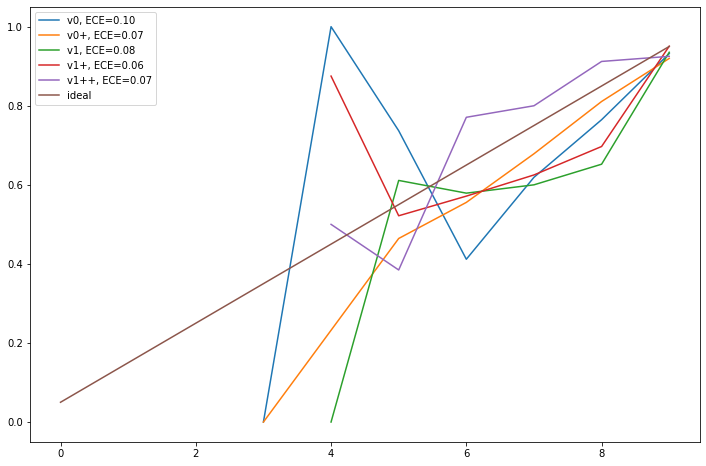

In [14]:
def plot_calibration(x_arr, y_arr, names):
    plt.figure(figsize=(12,8))
    for i in range(len(x_arr)):
        print(x_arr[i])
        print(y_arr[i])
        plt.plot(x_arr[i], y_arr[i])
    plt.plot(np.arange(10), np.arange(10)/10 + 0.05)
    plt.legend(names + ['ideal'])
    plt.show()
    
names = []
for i in range(len(ece_arr)):
    names.append("{}, ECE={:.2f}".format(methods[i], ece_arr[i]))
    
print(names)
plot_calibration(cal_x_arr, cal_y_arr, names)

In [18]:
# Conformal prediction using LABEL
for i in range(len(methods)):
    print(methods[i])
    y_test = df_test[i]['target_AS'].to_numpy(dtype=int)
    y_val = df_val[i]['target_AS'].to_numpy(dtype=int)
    #platt_coeffs = platt_scaling_fit(val_logits[i], y_val, mode="temp")
    #print(platt_coeffs)
    
    val_sm = preds_no_abs(val_preds[i])
    #val_sm_platt = softmax(val_logits[i]*platt_coeffs, axis=1)
    
    test_sm = preds_no_abs(test_preds[i])
    #test_sm_platt = softmax(test_logits[i]*platt_coeffs, axis=1)
    
    cov, bcov, card = develop_coverage_distribution(y_test, test_sm, n_splits=100, test_size=0.7, alpha=0.1)
    
    print(f"cov: {np.median(cov)}, {np.std(cov)}")
    print(f"bcov: {np.median(bcov)}, {np.std(bcov)}")
    print(f"card: {np.median(card)}, {np.std(card)}")
    
#     alphas = [0.12]
#     for a in alphas:
        
#         qhat = LABEL_fit(y_val, val_sm, alpha=a, verbose=False)
#         cs = LABEL_inference(test_sm,  qhat)
                
#         cov = coverage_test(y_test, cs)
#         bcov = balanced_coverage_test(y_test, cs)
#         card = cardinality_test(cs)
#         ordinal = ordinality_test_arr(cs)
#         print(f"Alpha({a}): cov={cov}, bcov={bcov}, card={card}, eff={bcov/card} ord={ordinal}")
        

v0
cov: 0.9281767955801105, 0.029663672352975252
bcov: 0.9281257393192308, 0.03174266793175086
card: 1.3977900552486189, 0.09754290333439854
v0+
cov: 0.9226519337016574, 0.0354750774607316
bcov: 0.9265768784061467, 0.03447143757519084
card: 1.4475138121546962, 0.12193739402170281
v1
cov: 0.9171270718232044, 0.03810452818926644
bcov: 0.9243760755241077, 0.03911677333221974
card: 1.3977900552486189, 0.1334340388185257
v1+
cov: 0.9226519337016574, 0.03175310726730191
bcov: 0.9235790095278961, 0.032094735566561214
card: 1.3812154696132597, 0.0967722416931056
v1++
cov: 0.9226519337016574, 0.041928533154572956
bcov: 0.9244313085341487, 0.041304465698971754
card: 1.4668508287292816, 0.14770115568601072
